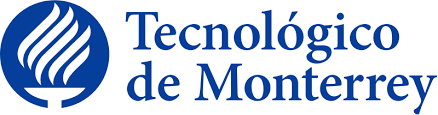

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey
###Asesor: Luis Eduardo Falcón Morales
## **Modelo Final Sentiment Analysisdistilbert-base-cased**
###**Equipo 18:**
###**A01793052 - Juan Carlos Lopez Cruz**


## **Libraries to install**

In [ ]:
!pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00


## **Libraries to be used**

In [ ]:
import torch


## Library for Datasets manipulation
from datasets import Dataset, load_dataset, DatasetDict

## Libraries to manipulate and plot data.
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Google Colab
from google.colab import files

# Libraries for Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Libraries for Transformer Data Generation and Text Clasiffication.
from evaluate import evaluator
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments,LineByLineTextDataset
from datasets import Dataset, load_dataset, DatasetDict, load_metric

#Library necesary to publish Transformer fine tunning.
from huggingface_hub import notebook_login

# **Load Data from Github**

In [ ]:
url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_comments.csv'
data= pd.read_csv(url)
data

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
1658,After reading about sudden accelerations in Je...,NaN
1659,My 2002 Jeep Grand Cherokee Limited takes off ...,NaN
1660,As I was braking at a stoplight my 2000 Jeep G...,NaN
1661,About 1 1/2 months ago my wife complained to m...,NaN


## **Recent Data to test model.**

This data was picked up from the https://www.edmunds.com/ website for Jeep Vehicles 2022,2023 and 2024. The reason to use data from different data set is to evaluate the robustness of the Model

In [ ]:
url2= 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_comments_fromedmunds.csv'
test_data=pd.read_csv(url2,encoding='latin1')
test_data

,text,stars,date,vehicle
0,"I special ordered my car , waited patiently fo...",1,6/25/2023,2024 Jeep Grand Cherokee L
1,Auto stop engine can not be permanently disabl...,2,12/30/2023,2023 Jeep Cherokee
2,I leased a high altitude in August 2034. I did...,1,12/30/2023,2024 Jeep Wrangler 4xe
3,Car is awesome! Couldnt be more happy with my...,5,12/30/2022,2024 Jeep Compass
4,Bought a brand new Rubicon for my son. Fully L...,1,12/30/2022,2024 Jeep Wrangler 4xe
...,...,...,...,...
303,Super happy with my purchase,5,06/01/2021,2023 Jeep Cherokee
304,Just the right size. the only complaint is the...,5,06/11/2020,2023 Jeep Renegade
305,This subcompact SUV is roomy enough for my fam...,5,09/10/2020,2023 Jeep Renegade
306,Gorgeous vehicle loaded with details comparabl...,5,12/09/2020,2023 Jeep Cherokee


# **EDA - Exploratory Data Analysis**

## **1- Elimination of nan rows.**

Since in the data extraction some reviews no rated, in these reviews the label was added **nan** , the first thing we must do is eliminate the data that does not have a label.

In [ ]:
nan_data = data.isna()
print(nan_data)

      Review  Stars
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
1658   False   True
1659   False   True
1660   False   True
1661   False   True
1662   False   True

[1663 rows x 2 columns]


In [ ]:
nan_test_data=test_data.isna()
print(nan_test_data)

      text  stars   date  vehicle
0    False  False  False    False
1    False  False  False    False
2    False  False  False    False
3    False  False  False    False
4    False  False  False    False
..     ...    ...    ...      ...
303  False  False  False    False
304  False  False  False    False
305  False  False  False    False
306  False  False  False    False
307  False  False  False    False

[308 rows x 4 columns]


In [ ]:
data_clean= data.dropna(subset=['Stars']) # dropna will eliminate nan reviews. (reviews not rated)
data_clean=data_clean.reset_index(drop=True) #restar index
data_clean

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,1.0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,1.0
961,"I purchased a 2011 Grand Cherokee in July, 201...",2.0
962,I have a 2003 Jeep Grand Cherokee and have had...,1.0


## **2- Creation of binary label.**

Convert the rates scale (1,2,3,4,5) to binary problem (0,1)

**Justification:**

When it comes to converting scores from a multi-class classification problem to a binary problem, there are different approaches that can be taken. A common way to approach this situation is to set a threshold to divide ratings into positive and negative.

In this case, if you want to consider ratings between 3 and 4 as 3.5, it is possible to set a threshold at 3.5 to classify the ratings as positive or negative. Any rating equal to or greater than 3.5 would be considered positive, while any rating below 3.5 would be considered negative.

This choice is based on the assumption that a rating of 3.5 is somewhere between positive ratings (greater than 3.5) and negative ratings (less than 3.5). By considering the rating of 3.5 as positive, it is being assumed that comments with a rating close to 3.5 still contain positive elements and should therefore be treated as such.

However, it is important to note that the choice of threshold may depend on the specific context and requirements of the problem. In some cases, it may be more appropriate to adjust the threshold to classify ratings between 3 and 4 as positive or negative. This will depend on the distribution of ratings and how the concept of "positive" and "negative" is defined in the context of the problem at hand. In our case let's decide to consider ratings greater than or equal to 4 as positive and those less than 4 as negative.

In [ ]:
ds = Dataset.from_dict({"text": data_clean.Review, "labels": [1 if star >= 4 else 0 for star in data_clean.Stars]})
ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 964
})

In [ ]:
ds.to_pandas()

,text,labels
0,Everything with them is 24 to 48 hours and eve...,0
1,So I went in to replace the hose radiator outl...,0
2,I was so excited to buy a Jeep but turns out i...,0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,0
4,I’m a mail carrier from the Dakotas.. so I pur...,0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,0
961,"I purchased a 2011 Grand Cherokee in July, 201...",0
962,I have a 2003 Jeep Grand Cherokee and have had...,0


## **Test data creation of binary**

In [ ]:
ds_test = Dataset.from_dict({"text": test_data.text, "labels": [1 if star >= 4 else 0 for star in test_data.stars]})
ds_test

Dataset({
    features: ['text', 'labels'],
    num_rows: 308
})

In [ ]:
ds_test.to_pandas()

,text,labels
0,"I special ordered my car , waited patiently fo...",0
1,Auto stop engine can not be permanently disabl...,0
2,I leased a high altitude in August 2034. I did...,0
3,Car is awesome! Couldnt be more happy with my...,1
4,Bought a brand new Rubicon for my son. Fully L...,0
...,...,...
303,Super happy with my purchase,1
304,Just the right size. the only complaint is the...,1
305,This subcompact SUV is roomy enough for my fam...,1
306,Gorgeous vehicle loaded with details comparabl...,1


We will Generate 2 files to storage comments rated and comments no rated related to Jeep brand.

In [ ]:
# Calculate the ratio of positive and negative tags
label_count = ds.to_pandas().labels.value_counts()
proportion_negative, proportion_positive = (label_count/len(ds['labels'])).tolist()
# Print the ratio of positive and negative labels
print(f"% of positive comments: {proportion_positive:.2f}")
print(f"% of negative comments: {proportion_negative:.2f}")

% of positive comments: 0.13
% of negative comments: 0.87


In [ ]:
label_count

0    841
1    123
Name: labels, dtype: int64

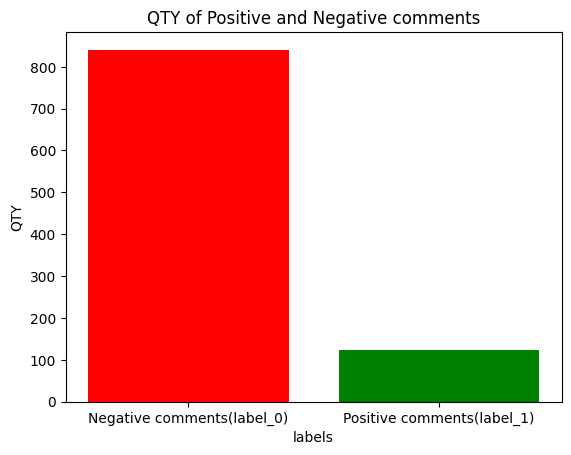

In [ ]:
# Plot the proportions
labels = ['Negative comments(label_0)', 'Positive comments(label_1)']
proportions = [proportion_positive, proportion_negative]

plt.bar(labels, label_count.tolist(), color=['red', 'green'])
plt.xlabel('labels')
plt.ylabel('QTY')
plt.title('QTY of Positive and Negative comments')
plt.show()

In [ ]:
ds_copy = ds.map()

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

# **Data Split for Train and Val.**

In [ ]:
def split_dataset(ds):

    ds = ds.class_encode_column ('labels')

    train_test_valid = ds.train_test_split(test_size=0.2, seed=42, stratify_by_column='labels')


    test_valid = train_test_valid['test'].train_test_split(test_size=0.5, seed = 42, stratify_by_column='labels')


    return DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
ds_split = split_dataset(ds)
ds_split

Stringifying the column:   0%|          | 0/964 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/964 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 771
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 97
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 96
    })
})

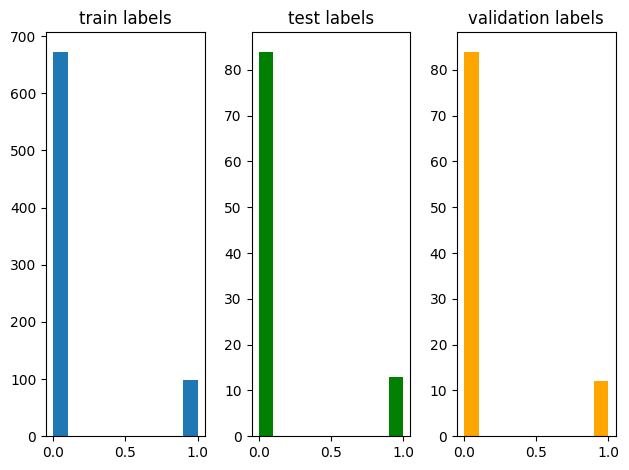

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(ds_split['train']['labels'])
ax2.set_title('test labels')
ax2.hist(ds_split['test']['labels'],color='green')
ax3.set_title('validation labels')
ax3.hist(ds_split['valid']['labels'],color='orange')
fig.tight_layout()

# **Load Augmented Data from Github**

In [ ]:
ds_aug_split=ds_split.map()
#url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_synthetic_comments.csv' # Data w/o fine tuning
url="https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_synthetic_comments%20V2.csv" # Data with Fine tuning
ds_synthetic= pd.read_csv(url)
ds_synthetic

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

,text,labels
0,"Jeep vehicle is a great car, but I can't get o...",1
1,"I love jeep car, but this is a brand new vehic...",1
2,My jeep car is the best I have ever had. I wil...,1
3,"I really enjoy jeep cars, but it is a very dan...",1
4,I will buy another jeep car again. I will neve...,1
...,...,...
415,I will never buy again a jeep car.\nI bought a...,0
416,Jeep vehicle is the worse car I have ever owne...,0
417,I do not like jeep car’s. I have owned many je...,0
418,My jeep car is bad. I have never had anything ...,0


In [ ]:
positive_comments = ds_synthetic [ds_synthetic.labels== 1]
negative_comments= ds_synthetic[ds_synthetic.labels== 0]

In [ ]:
positive_comments.head()

,text,labels
0,"Jeep vehicle is a great car, but I can't get o...",1
1,"I love jeep car, but this is a brand new vehic...",1
2,My jeep car is the best I have ever had. I wil...,1
3,"I really enjoy jeep cars, but it is a very dan...",1
4,I will buy another jeep car again. I will neve...,1


In [ ]:
negative_comments.head()

,text,labels
400,Jeep vehicle is the worse car I have ever owne...,0
401,I do not like jeep car. I have owned several j...,0
402,My jeep car is bad. The engine light comes on ...,0
403,I will never buy again a jeep car. I have had ...,0
404,Jeep vehicle is the worse car I have ever owne...,0


In [ ]:
for comment, label in zip(negative_comments.text, negative_comments.labels): ds_aug_split['train'] = ds_aug_split['train'].add_item({'text': comment, 'labels': label})
for comment, label in zip(positive_comments.text, positive_comments.labels): ds_aug_split['train'] = ds_aug_split['train'].add_item({'text': comment, 'labels': label})

In [ ]:
ds_aug_split

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1191
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 97
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 96
    })
})

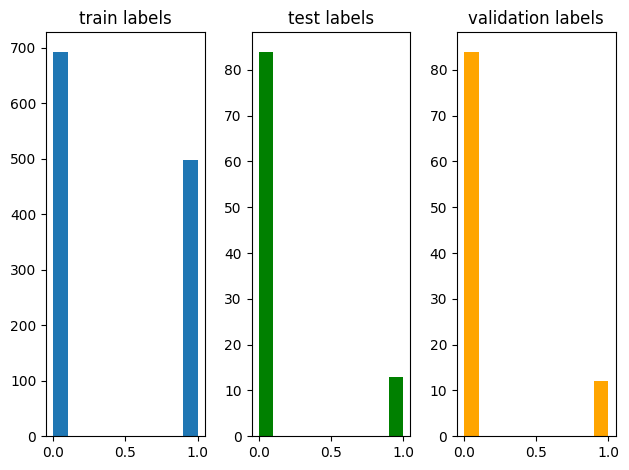

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(ds_aug_split['train']['labels'])
ax2.set_title('test labels')
ax2.hist(ds_aug_split['test']['labels'],color='green')
ax3.set_title('validation labels')
ax3.hist(ds_aug_split['valid']['labels'],color='orange')
fig.tight_layout()

#**Sentiment Analysis using -Transformer "distilbert-base-cased"**

Train with PyTorch Trainer

## **1- Load transformer model tokenizer and tokenize the data sets.**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = ds_split.map(tokenize_function, batched=True)
tokenized_dataset_test=ds_test.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
valid_dataset = tokenized_datasets["valid"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)
test2_dataset = tokenized_dataset_test.shuffle(seed=42) # Dataset from different website.


##**2-Verify and define the device to work**

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device(torch.cuda.current_device())
    else:
        return torch.device('cpu')

In [ ]:
get_device()

device(type='cuda', index=0)

## **3- Load Transformer model for clasification**

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(get_device())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

##**4- Define the compute metric**

In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

##**5-Define the training arguments and Trainer**

In [ ]:
from datetime import datetime

def get_training_args():
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = f"test_trainer_{timestamp}"

    return TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch")

In [ ]:
training_args = get_training_args()
#training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=5)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

## **6-Train the Model and Evaluate the model**

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.269662,0.875000
2,No log,0.255422,0.937500
3,No log,0.252271,0.947917
4,No log,0.249763,0.947917


TrainOutput(global_step=100, training_loss=0.19705575942993164, metrics={'train_runtime': 207.7193, 'train_samples_per_second': 14.847, 'train_steps_per_second': 0.481, 'total_flos': 408529457455104.0, 'train_loss': 0.19705575942993164, 'epoch': 4.0})

In [ ]:
train_results=pd.DataFrame(trainer.evaluate(train_dataset),index=['Resultado'])
train_result=train_results['eval_accuracy'].item()*100
train_results


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Resultado,0.082432,0.972763,34.6595,22.245,2.799,4.0


In [ ]:
val_results=pd.DataFrame(trainer.evaluate(valid_dataset),index=['Resultado'])
val_result=val_results['eval_accuracy'].item()*100
val_results

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Resultado,0.249763,0.947917,3.9803,24.119,3.015,4.0


In [ ]:
test_results=pd.DataFrame(trainer.evaluate(test_dataset),index=['Resultado'])
test_results

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Resultado,0.096625,0.958763,7.8837,12.304,1.649,4.0


In [ ]:
test2_results=pd.DataFrame(trainer.evaluate(test2_dataset),index=['Resultado'])
test2_results

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Resultado,0.540497,0.847403,12.991,23.709,3.002,4.0


## **7-Visual review of the Data predictions**

### **Using test dataset form the same database**

In [ ]:
predictions = trainer.predict(test_dataset)
final_preds = [{ 'text': test_dataset['text'][i], 'pred': pred, 'label': test_dataset['labels'][i] } for i,pred in enumerate(predictions.predictions.argmax(-1))]

In [ ]:
df_pred_tuned = pd.DataFrame(final_preds)
df_pred_tuned.to_excel('predictions_distilbert.xlsx')
files.download('predictions_distilbert.xlsx')
df_pred_tuned

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,text,pred,label
0,Buying my 2014 Jeep Cherokee less than a month...,0,0
1,I called last week to simply find out a price ...,0,0
2,Bought a 2014 Jeep Cherokee Sport in December ...,0,0
3,Third Jeep Grand Cherokee and third Jeep with ...,0,0
4,"I bought my 2017 Jeep Compass brand new, the 8...",0,0
...,...,...,...
92,I purchase my 2014 Jeep Cherokee in April 2014...,0,0
93,We have not purchased a new car since 2004. We...,0,0
94,"On Friday, March 4, after going grocery shoppi...",0,0
95,I have a 2006 Jeep Liberty and about a year an...,0,0


### **Using test2 dataset form the data from diferent website**

In [ ]:
predictions2 = trainer.predict(test2_dataset)
final_preds2 = [{ 'text': test2_dataset['text'][i], 'pred': pred, 'label': test2_dataset['labels'][i] } for i,pred in enumerate(predictions2.predictions.argmax(-1))]

In [ ]:
df_pred_tuned2 = pd.DataFrame(final_preds2)
df_pred_tuned2.to_excel('predictions_distilbert2.xlsx')
files.download('predictions_distilbert2.xlsx')
df_pred_tuned2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,text,pred,label
0,I love the highup feeling in the Jeep as we ri...,1,1
1,I Bought the 2023 jeep grand Cherokee limited ...,0,0
2,"Ive only had the Jeep for a week, so far I lo...",1,1
3,This is the first brand new SUV I have bought....,1,1
4,Love the features and color. Great for our add...,1,1
...,...,...,...
303,We love our 2022! This is a new plug-in hybrid...,1,1
304,This is my 3rd Renegade and I love it! So cute...,1,1
305,I have this on loan while my minivan is being ...,1,0
306,Great ride!,1,1


## **8-Confusion Matrix Evaluation**

### **Using test dataset form the same database**

Matriz de confusión - finetuning-sentiment-model-Jeep_comments_test_data
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        84
           1       0.85      0.85      0.85        13

    accuracy                           0.96        97
   macro avg       0.91      0.91      0.91        97
weighted avg       0.96      0.96      0.96        97



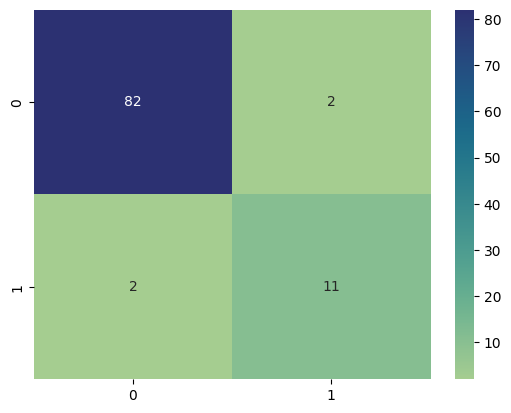

In [ ]:
cm_tuned = confusion_matrix(df_pred_tuned['label'],df_pred_tuned['pred'])
sns.heatmap(cm_tuned, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - finetuning-sentiment-model-Jeep_comments_test_data")
print(classification_report(df_pred_tuned['label'],df_pred_tuned['pred']))

In [ ]:
bert_tunning_test=classification_report(df_pred_tuned['label'],df_pred_tuned['pred'],output_dict=True)
bert_tunning_test=pd.DataFrame(bert_tunning_test)
bert_tunning_test= bert_tunning_test.transpose()
bert_tunning_test

,precision,recall,f1-score,support
0,0.976190,0.976190,0.976190,84.000000
1,0.846154,0.846154,0.846154,13.000000
accuracy,0.958763,0.958763,0.958763,0.958763
macro avg,0.911172,0.911172,0.911172,97.000000
weighted avg,0.958763,0.958763,0.958763,97.000000


### **Using test dataset form the same database**

Matriz de confusión - finetuning-sentiment-model-Jeep_comments_test2_data
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        88
           1       0.94      0.84      0.89       220

    accuracy                           0.85       308
   macro avg       0.81      0.86      0.83       308
weighted avg       0.87      0.85      0.85       308



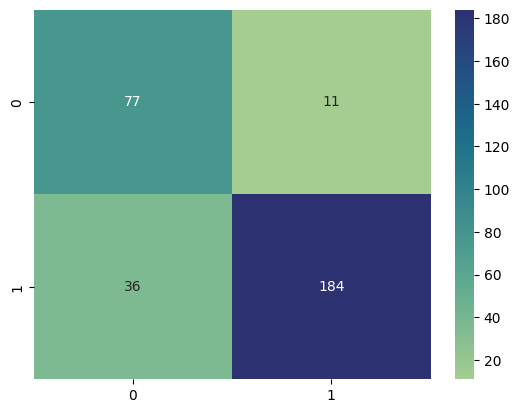

In [ ]:
cm_tuned = confusion_matrix(df_pred_tuned2['label'],df_pred_tuned2['pred'])
sns.heatmap(cm_tuned, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - finetuning-sentiment-model-Jeep_comments_test2_data")
print(classification_report(df_pred_tuned2['label'],df_pred_tuned2['pred']))

In [ ]:
bert_tunning_test2=classification_report(df_pred_tuned2['label'],df_pred_tuned2['pred'],output_dict=True)
bert_tunning_test2=pd.DataFrame(bert_tunning_test2)
bert_tunning_test2= bert_tunning_test2.transpose()
bert_tunning_test2

,precision,recall,f1-score,support
0,0.681416,0.875000,0.766169,88.000000
1,0.943590,0.836364,0.886747,220.000000
accuracy,0.847403,0.847403,0.847403,0.847403
macro avg,0.812503,0.855682,0.826458,308.000000
weighted avg,0.868683,0.847403,0.852296,308.000000


#**Sentiment Analysis using -Transformer "distilbert-base-cased"**  <font color='Blue'> with Data Augmented
Train with PyTorch Trainer

## **tokenize the data sets.**

In [ ]:
tokenized_datasets = ds_aug_split.map(tokenize_function, batched=True)
tokenized_dataset_test=ds_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1191 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1191
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 97
    })
    valid: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 96
    })
})

In [ ]:
train_dataset_a = tokenized_datasets["train"].shuffle(seed=42)

## **Load Transformer model for clasification**

In [ ]:
from transformers import AutoModelForSequenceClassification

model_a = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model_a.to(get_device())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

##**Define the training arguments and Trainer**

In [ ]:
from datetime import datetime

def get_training_args():
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = f"test_trainer_{timestamp}"

    return TrainingArguments(
    output_dir=output_dir,
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch")

In [ ]:
training_args_a = get_training_args()
#training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=5)

In [ ]:
trainer_a = Trainer(
    model=model_a,
    args=training_args_a,
    train_dataset=train_dataset_a,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

## **Train the Model and Evaluate the model**

In [ ]:
trainer_a.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.233153,0.947917
2,No log,0.235034,0.937500
3,No log,0.243288,0.937500
4,No log,0.229564,0.937500


TrainOutput(global_step=152, training_loss=0.1453899207868074, metrics={'train_runtime': 308.1053, 'train_samples_per_second': 15.462, 'train_steps_per_second': 0.493, 'total_flos': 631074687197184.0, 'train_loss': 0.1453899207868074, 'epoch': 4.0})

In [ ]:
train_results_a=pd.DataFrame(trainer_a.evaluate(train_dataset_a),index=['Results_training_a'])
train_result_a=train_results_a['eval_accuracy'].item()*100
train_results_a

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Results_training_a,0.049425,0.987406,51.8571,22.967,2.873,4.0


In [ ]:
val_results_a=pd.DataFrame(trainer_a.evaluate(valid_dataset),index=['Results_validation_a'])
val_result_a=val_results_a['eval_accuracy'].item()*100
val_results_a

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Results_validation_a,0.229564,0.9375,3.552,27.027,3.378,4.0


In [ ]:
test_results_a=pd.DataFrame(trainer_a.evaluate(test_dataset),index=['Results_test_a'])
test_results_a

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Results_test_a,0.079714,0.969072,4.9103,19.755,2.648,4.0


In [ ]:
test2_results_a=pd.DataFrame(trainer_a.evaluate(test2_dataset),index=['Results_test2_a'])
test2_results_a

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Results_test2_a,0.604137,0.801948,13.7409,22.415,2.838,4.0


## **Visual review of the Data predictions**

### **Using test dataset form the same database**

In [ ]:
predictions_a = trainer_a.predict(test_dataset)
final_preds = [{ 'text': test_dataset['text'][i], 'pred': pred, 'label': test_dataset['labels'][i] } for i,pred in enumerate(predictions_a.predictions.argmax(-1))]
df_pred_tuned_a = pd.DataFrame(final_preds)
df_pred_tuned_a.to_excel('predictions_distilbert_a.xlsx')
files.download('predictions_distilbert_a.xlsx')
df_pred_tuned_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,text,pred,label
0,Buying my 2014 Jeep Cherokee less than a month...,0,0
1,I called last week to simply find out a price ...,0,0
2,Bought a 2014 Jeep Cherokee Sport in December ...,0,0
3,Third Jeep Grand Cherokee and third Jeep with ...,0,0
4,"I bought my 2017 Jeep Compass brand new, the 8...",0,0
...,...,...,...
92,I purchase my 2014 Jeep Cherokee in April 2014...,0,0
93,We have not purchased a new car since 2004. We...,0,0
94,"On Friday, March 4, after going grocery shoppi...",0,0
95,I have a 2006 Jeep Liberty and about a year an...,0,0


### **Using test2 dataset form the data from diferent website**

In [ ]:
predictions2_a = trainer_a.predict(test2_dataset)
final_preds2_a = [{ 'text': test2_dataset['text'][i], 'pred': pred, 'label': test2_dataset['labels'][i] } for i,pred in enumerate(predictions2_a.predictions.argmax(-1))]
df_pred_tuned2_a = pd.DataFrame(final_preds2_a)
df_pred_tuned2_a.to_excel('predictions_distilbert2_a.xlsx')
files.download('predictions_distilbert2_a.xlsx')
df_pred_tuned2_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,text,pred,label
0,I love the highup feeling in the Jeep as we ri...,1,1
1,I Bought the 2023 jeep grand Cherokee limited ...,0,0
2,"Ive only had the Jeep for a week, so far I lo...",1,1
3,This is the first brand new SUV I have bought....,1,1
4,Love the features and color. Great for our add...,1,1
...,...,...,...
303,We love our 2022! This is a new plug-in hybrid...,1,1
304,This is my 3rd Renegade and I love it! So cute...,1,1
305,I have this on loan while my minivan is being ...,0,0
306,Great ride!,1,1


## **Confusion Matrix Evaluation (Model Evaluation)**

### **Using test dataset form the same database**

Confusion Matriz- finetuning-sentiment-with data augmentation-jeep-customer-review
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        84
           1       0.92      0.85      0.88        13

    accuracy                           0.97        97
   macro avg       0.95      0.92      0.93        97
weighted avg       0.97      0.97      0.97        97



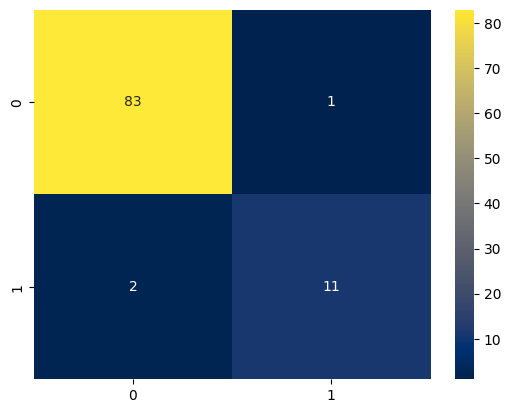

In [ ]:
cm_tuned = confusion_matrix(df_pred_tuned_a['label'],df_pred_tuned_a['pred'])
sns.heatmap(cm_tuned, annot=True, fmt = "d",cmap="cividis")
print("Confusion Matriz- finetuning-sentiment-with data augmentation-jeep-customer-review")
print(classification_report(df_pred_tuned_a['label'],df_pred_tuned_a['pred']))

In [ ]:
bert_tunning_test_a=classification_report(df_pred_tuned_a['label'],df_pred_tuned_a['pred'],output_dict=True)
bert_tunning_test_a=pd.DataFrame(bert_tunning_test_a)
bert_tunning_test_a= bert_tunning_test_a.transpose()
bert_tunning_test_a

,precision,recall,f1-score,support
0,0.976471,0.988095,0.982249,84.000000
1,0.916667,0.846154,0.880000,13.000000
accuracy,0.969072,0.969072,0.969072,0.969072
macro avg,0.946569,0.917125,0.931124,97.000000
weighted avg,0.968456,0.969072,0.968545,97.000000


### **Using test dataset form the 2nd Data Base**

Confusion Matriz- finetuning-sentiment-with data augmentation-jeep-customer-review_test2_data
              precision    recall  f1-score   support

           0       0.60      0.93      0.73        88
           1       0.96      0.75      0.84       220

    accuracy                           0.80       308
   macro avg       0.78      0.84      0.79       308
weighted avg       0.86      0.80      0.81       308



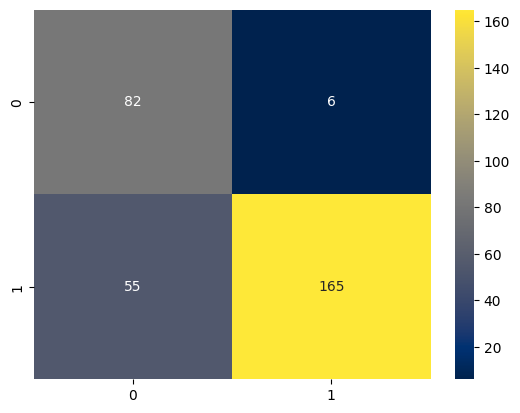

In [ ]:
cm_tuned = confusion_matrix(df_pred_tuned2_a['label'],df_pred_tuned2_a['pred'])
sns.heatmap(cm_tuned, annot=True, fmt = "d",cmap="cividis")
print("Confusion Matriz- finetuning-sentiment-with data augmentation-jeep-customer-review_test2_data")
print(classification_report(df_pred_tuned2_a['label'],df_pred_tuned2_a['pred']))

In [ ]:
bert_tunning_test2_a=classification_report(df_pred_tuned2_a['label'],df_pred_tuned2_a['pred'],output_dict=True)
bert_tunning_test2_a=pd.DataFrame(bert_tunning_test2_a)
bert_tunning_test2_a= bert_tunning_test2_a.transpose()
bert_tunning_test2_a

,precision,recall,f1-score,support
0,0.598540,0.931818,0.728889,88.000000
1,0.964912,0.750000,0.843990,220.000000
accuracy,0.801948,0.801948,0.801948,0.801948
macro avg,0.781726,0.840909,0.786439,308.000000
weighted avg,0.860235,0.801948,0.811104,308.000000


# **Reports**

In [ ]:
## all the train results
train_results_acc = {
    'Train-accuracy': [train_result,train_result_a],
    'Val-accuracy': [val_result,val_result_a],
    'Difference' : [(train_result-val_result),(train_result_a-val_result_a)]
}
train_results_acc=pd.DataFrame(train_results_acc,index=['distilbert_tunned', 'distilbert_tunned_a']).T
train_results_acc.to_excel('train_results_distilbert.xlsx')
files.download('train_results_distilbert.xlsx')
train_results_acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,distilbert_tunned,distilbert_tunned_a
Train-accuracy,97.276265,98.740554
Val-accuracy,94.791667,93.750000
Difference,2.484598,4.990554


In [ ]:
model_eval_restuls=pd.concat([bert_tunning_test,bert_tunning_test2,
                              bert_tunning_test_a,bert_tunning_test2_a],
                   axis=1,
                   keys=['distilbert_tuned_test','distilbert_tuned_test2',
                         'distilbert_tuned_test_a','distilbert_tuned_test2_a'])

model_eval_restuls.to_excel('results_distilbert.xlsx')
files.download('results_distilbert.xlsx')

model_eval_restuls

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

distilbert_tuned_test                                 \
                         precision    recall  f1-score    support   
0                         0.976190  0.976190  0.976190  84.000000   
1                         0.846154  0.846154  0.846154  13.000000   
accuracy                  0.958763  0.958763  0.958763   0.958763   
macro avg                 0.911172  0.911172  0.911172  97.000000   
weighted avg              0.958763  0.958763  0.958763  97.000000   

             distilbert_tuned_test2                                  \
                          precision    recall  f1-score     support   
0                          0.681416  0.875000  0.766169   88.000000   
1                          0.943590  0.836364  0.886747  220.000000   
accuracy                   0.847403  0.847403  0.847403    0.847403   
macro avg                  0.812503  0.855682  0.826458  308.000000   
weighted avg               0.868683  0.847403  0.852296  308.000000   

             distilbert_tuned_test_a                                 \
                           precision    recall  f1-score    support   
0                           0.976471  0.988095  0.982249  84.000000   
1                           0.916667  0.846154  0.880000  13.000000   
accuracy                    0.969072  0.969072  0.969072   0.969072   
macro avg                   0.946569  0.917125  0.931124  97.000000   
weighted avg                0.968456  0.969072  0.968545  97.000000   

             distilbert_tuned_test2_a                                  
                            precision    recall  f1-score     support  
0                            0.598540  0.931818  0.728889   88.000000  
1                            0.964912  0.750000  0.843990  220.000000  
accuracy                     0.801948  0.801948  0.801948    0.801948  
macro avg                    0.781726  0.840909  0.786439  308.000000  
weighted avg                 0.860235  0.801948  0.811104  308.000000

In [ ]:
f1_scores = model_eval_restuls.xs('f1-score', axis=1, level=1)
f1_scores = f1_scores.rename_axis("f1-scores", axis="columns")
f1_scores.to_excel('f1scores_distilbert.xlsx')
files.download('f1scores_distilbert.xlsx')
f1_scores

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

f1-scores,distilbert_tuned_test,distilbert_tuned_test2,distilbert_tuned_test_a,distilbert_tuned_test2_a
0,0.976190,0.766169,0.982249,0.728889
1,0.846154,0.886747,0.880000,0.843990
accuracy,0.958763,0.847403,0.969072,0.801948
macro avg,0.911172,0.826458,0.931124,0.786439
weighted avg,0.958763,0.852296,0.968545,0.811104


# **Conclusions:**


After evaluating the logistic regression model with different the following variants:
- distilbert_tunned	-> distilbert-base-cased with Fine tunning
- distilbert_tunned_a -> distilbert-base-cased with fine tunning and  training data augmentation

We obtained the following training results.

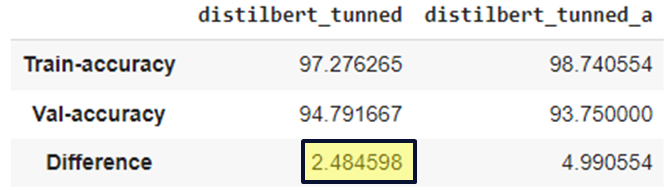

Where we can see that the best model is **distilbert_tunned** The answer to the question why it is the best model is because it shows a difference in accuracy between training and validation of 2.48%.


Another point to evaluate is when using the data partition test data set and using a data set extracted from another website called https://www.edmunds.com/. For this, we proceeded to evaluate with the F1-score metric for the following reasons.

Good for imbalanced classes: When the classes in the test data are imbalanced (that is, there are many more instances of one class than another), accuracy alone can be misleading. For example, a model that always predicts the majority class could have high precision but very low recall. The F1-score takes into account both precision and recall, making it more suitable for evaluating models in cases of imbalanced classes.

Shows a balance between precision and recall: The F1-score is a metric that combines the model's precision and recall into a single measure. This is useful because there is often a trade-off between precision and recall: increasing precision can reduce recall and vice versa. The F1-score provides a way to evaluate the balance between these two aspects of model performance.

The following results show the f-1 score values for each model configuration showing the test with the data from the same website (test) and with the data from another website (test2)

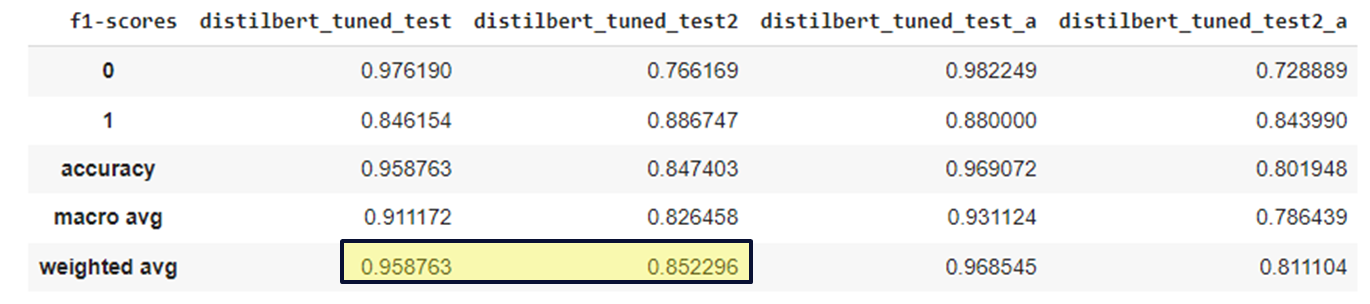

The results show **distilbert_tunned ** as the one that offers a better balance between the classes if we consider macro avg that averages the value of f1-score for class 0 and class 1. And it shows less difference comparing the test data from the same website(test) compared to the website(test2).

To conclude,  the **distilbert_tunned ** model showed better results compared to model with Agumentation, the model with Augmentation showed more overtraining.

Something that is observed is that in all cases the data Augmentation (the comments generated with GPT2) did not provide a benefit to improve the models and when evaluating them with data that were not seen during training, in some cases their f1-score values were reduced.

# **References:**

- Hugging Face. (s.f.). Text generation strategies. En Hugging Face Transformers Documentation. Recuperado de https://huggingface.co/docs/transformers/en/generation_strategies#diverse-beam-search-decoding

- Liu, X. (s.f.). distilbert-base-multilingual-cased-sentiments-student. Hugging Face. Recuperado de https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

- Hugging Face. (s.f.). Transformers: Training & Fine-Tuning. Recuperado de https://huggingface.co/docs/transformers/training

- ParseHub. (n.d.). What Is Web Scraping? | ParseHub. ParseHub. Retrieved January 28, 2024, from https://www.parsehub.com/blog/what-is-web-scraping/

- Falcón Morales, L. E. (2023). Maestría en Inteligencia Artificial Aplicada. ITESM

- Kumar Mukhiya, S., y Ahmed, U. (2020). Hands-On Exploratory Data Analysis with Python. Packt Publishing.

- Hugging Face. (n.d.). Trainer — transformers 4.15.0 documentation. Retrieved from https://huggingface.co/docs/transformers/v4.15.0/en/main_classes/trainer#trainer